# Product Recognition on Store Shelves
## Computer Vision and Image Processing - Exam project
### Valentina Protti - 0000853631

## ----------------------------------------------------------- Step A: -----------------------------------------------------------

**Step A - Multiple Product Detection:**

>Test on scene image: {e1.png, e2.png, e3.png, e4.png, e5.png}<br>
>Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

In [7]:
# Support fncs - Step A
def set_flann_matcher():
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    return flann

def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

def img_num(path):
    return path.partition("/")[2].partition(".jpg")[0]

def delete_keypoints(corners, kp_train):
    ppx, ppy = zip(*corners)
    mins = [min(ppx), min(ppy)]
    maxs = [max(ppx), max(ppy)]
    to_delete = []
    for idx in range(0, len(kp_train)-1):
        pt = kp_train[idx].pt
        # If the keypoint falls inside the bounding box, it gets deleted
        if (mins[0] <= pt[0] <= maxs[0]) and (mins[1] <= pt[1] <= maxs[1]):
            to_delete.append(idx)
    kp_train = np.delete(kp_train, [ i for i in to_delete ])
    # It wouldn't be correct to delete ALL keypoints considered good by the matching process,
    # because they could still belong to a match with another image
    #kp_train = np.delete(kp_train, [ m.trainIdx for m in good ])
    return kp_train

def check_ratio(h_old, w_old, corners):
    # Computing the new height and width of the found object
    h_r = distance(corners[0], corners[1])
    h_l = distance(corners[2], corners[3])
    h_new = (h_r+h_l)/2
    w_t = distance(corners[1], corners[2])
    w_b = distance(corners[0], corners[3])
    w_new = (w_t+w_b)/2
    
    if (np.abs((h_new/w_new) - (h_old/w_old)) < 0.20):
        return True, h_new, w_new
    else:
        return False, h_new, w_new
    
def is_rectangle(corners):
    x,y = zip(*corners)
    # In order to determine if the shape is rectangle-like, we can compute the angles
    # between the given corners and state they need to be as similar to 90deg as possible
    # We only need to compute two of the four corners
    # angle1 on corner p0, angle2 on corner p2
    angle1 = math.atan2(y[3] - y[0], x[3] - x[0]) - math.atan2(y[1] - y[0], x[1] - x[0])
    angle2 = math.atan2(y[1] - y[2], x[1] - x[2]) - math.atan2(y[3] - y[2], x[3] - x[2])
    angle1 = np.abs(math.degrees(angle1))
    angle2 = np.abs(math.degrees(angle2))
    
    if ((np.abs(angle1 - 90) < 10 or (np.abs(angle1 - 270) < 10)) and
        (np.abs(angle2 - 90) < 10 or (np.abs(angle2 - 270) < 10))):
        return True
    else:
        return False

def find_centroid(points):
    centroid = (points.mean(axis=0)).reshape(2)
    return centroid

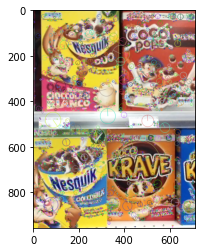

End of model nr. 0; position: (158.73,739.53), width: 324.91px, height: 439.88px
End of model nr. 1; position: (464.59,688.08), width: 298.15px, height: 389.79px
End of model nr. 25; position: (555.46,209.11), width: 323.54px, height: 448.38px
End of model nr. 26; position: (205.59,195.67), width: 340.96px, height: 493.49px


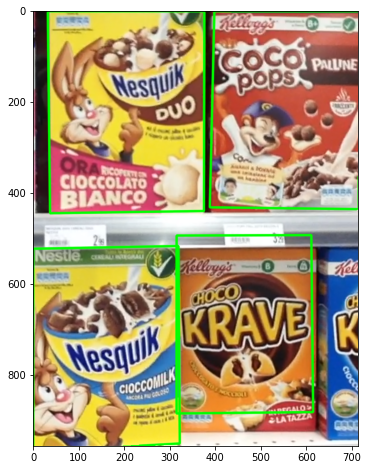

In [9]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt

# 'scenes/e1.png', 'scenes/e2.png', 'scenes/e3.png', 'scenes/e4.png', 'scenes/e5.png'
img_train = cv2.imread('scenes/e4.png')[:,:,::-1] # trainImage
img_querys = ['models/0.jpg',
              'models/1.jpg',
              'models/11.jpg',
              'models/19.jpg',
              'models/24.jpg',
              'models/25.jpg',
              'models/26.jpg'] # queryImages

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_train = sift.detect(img_train)

# Visualize keypoints with drawKeypoints.
img = cv2.drawKeypoints(img_train,kp_train,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()

# Defining parameters for algorithm
flann = set_flann_matcher()

for path in img_querys:
    kp_train, des_train = sift.compute(img_train, kp_train)
    
    img_query = cv2.imread(path)[:,:,::-1] # queryImage
    kp_query = sift.detect(img_query)
    kp_query, des_query = sift.compute(img_query, kp_query)
    
    # Matching and finding the 2 closest elements for each query descriptor
    matches = flann.knnMatch(des_query,des_train,k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
        
    # Checking if we found enough matching
    MIN_MATCH_COUNT = 70
    if len(good)>MIN_MATCH_COUNT:
        # building the corrspondences arrays of good matches
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        # Using RANSAC to estimate a robust homography. 
        # It returns the homography M and a mask for the discarded points
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Mask of discarded point used in visualization
        matchesMask = mask.ravel().tolist()
        
        # Corners of the query image
        h,w = img_query.shape[:2]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        
        # Projecting the corners into the train image
        dst = cv2.perspectiveTransform(pts,M)
        
        # In order to avoid wrong matches without increasing too much the min number of keypoint matches,
        # that would instead result in discarding right matches with a low number of keypoints,
        # we compare the height/width ratio of the model object to the ratio of the found object
        # and reject the wrongfully found match (ratios too different).
        # A second test has been added in order to check how rectangular-like is the shape of
        # the found object.
        flag1 = is_rectangle(dst.reshape(4,2))
        flag2, h_new, w_new = check_ratio(h, w, dst.reshape(4,2))
        if flag1 and flag2:
            # Compute the centroid of the corners, thus of the found object
            centroid = find_centroid(dst)
            
            # Some points may fall outside scene image boundaries after the perspective transformation,
            # and that may be due to partially cut images. The two lines below are just to prevent the error
            # that would come up when trying to draw them.
            for i in dst:
                i[i<0] = 0
            
            # Drawing the bounding box
            # cv2.polylines(img, pts, isClosed, color[, thickness[, lineType[, shift]]])
            img_train = cv2.polylines(np.array(img_train),[dst.astype(np.int32)],True,[0,255,0],3,cv2.LINE_AA)
            
            # Update: delete set of keypoints of the object detected, not to be matched again with next models
            kp_train = delete_keypoints(dst.reshape(4,2), kp_train)
            print("End of model nr. {}; position: ({},{}), width: {}px, height: {}px".format(img_num(path), format(centroid[0], '.2f'), format(centroid[1], '.2f'), format(w_new, '.2f'), format(h_new, '.2f')))
#         else:
#             reason = ''
#             if not flag1:
#                 reason += 'shape not rectangular; '
#             if not flag2:
#                 reason += 'h/w ratio; '
#             print("REJECTED nr. {} due to {}".format(img_num(path), reason))
    else:
#         print( "{}: Not enough matches are found - {}/{}".format(path, len(good), MIN_MATCH_COUNT) )
        matchesMask = None
    
plt.figure(figsize=(16,8))
plt.imshow(img_train)
plt.show()

## ----------------------------------------------------------- Step B: -----------------------------------------------------------

**Step B - Multiple Instance Detection:**

>Test on scene image: {m1.png, m2.png, m3.png, m4.png, m5.png}<br>
>Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

In [16]:
# Support fncs - Step B
def perform_clustering(votes, img, n_corr):
    # Standardization of data to perform DBSCAN clustering
    
    X = StandardScaler().fit_transform(votes)
    print(X.shape)

    # #############################################################################

    # Compute DBSCAN
    min_s = n_corr/3
    db = DBSCAN(eps=0.15, min_samples=min_s).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # #############################################################################

    # Visualization of clusters
#     unique_labels = set(labels)
#     colors = [[255,0,0],
#               [0,255,0],
#               [0,0,255],
#               [255,255,0],
#               [255,0,255],
#               [0,255,255],
#               [255,255,255],
#               [0,0,0]]
#     img_cpyb = img.copy()
#     for k, col in zip(unique_labels, colors):
#         if k == -1:
#             # Black used for noise.
#             col = [0, 0, 0]

#         class_member_mask = (labels == k)

#         xy = votes[class_member_mask & core_samples_mask]
#         for point in xy:
#             cv2.circle(img_cpyb, (point[0].astype(np.int32),point[1].astype(np.int32)), 14, col, cv2.FILLED, cv2.LINE_AA)
#         #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#         #         markeredgecolor='k', markersize=14)

#         xy = votes[class_member_mask & ~core_samples_mask]
#         for point in xy:
#             cv2.circle(img_cpyb, (point[0].astype(np.int32),point[1].astype(np.int32)), 6, col, cv2.FILLED, cv2.LINE_AA)
#         #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#         #         markeredgecolor='k', markersize=6)
#     plt.figure(figsize=(16,8))
#     plt.imshow(img_cpyb)
#     plt.show()
    
    return labels
    
def perform_clustering_hdbscan(votes, img, n_corr):

    # #############################################################################

    # Compute HDBSCAN
    min_s = int(n_corr/3)
    db = hdbscan.HDBSCAN(min_cluster_size=min_s)
    labels = db.fit_predict(votes)

    # #############################################################################

    # Visualization of clusters
#     unique_labels = set(labels)
#     colors = [[255,0,0],
#               [0,255,0],
#               [0,0,255],
#               [255,255,0],
#               [255,0,255],
#               [0,255,255],
#               [255,255,255],
#               [0,0,0]]
#     img_cpyb = img.copy()
#     for k, col in zip(unique_labels, colors):
#         if k == -1:
#             # Black used for noise.
#             col = [0, 0, 0]

#         class_member_mask = (labels == k)

#         xy = votes[class_member_mask]
#         for point in xy:
#             cv2.circle(img_cpyb, (point[0].astype(np.int32),point[1].astype(np.int32)), 6, col, cv2.FILLED, cv2.LINE_AA)
#         #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#         #         markeredgecolor='k', markersize=14)
        
#     plt.figure(figsize=(16,8))
#     plt.imshow(img_cpyb)
#     plt.show()
    
    return labels

def set_flann_matcher():
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    return flann

def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

def img_num(path):
    return path.partition("/")[2].partition(".jpg")[0]

def delete_keypoints(corners, kp_train):
    ppx, ppy = zip(*corners)
    mins = [min(ppx), min(ppy)]
    maxs = [max(ppx), max(ppy)]
    to_delete = []
    for idx in range(0, len(kp_train)-1):
        pt = kp_train[idx].pt
        # If the keypoint falls inside the bounding box, it gets deleted
        if (mins[0] <= pt[0] <= maxs[0]) and (mins[1] <= pt[1] <= maxs[1]):
            to_delete.append(idx)
    kp_train = np.delete(kp_train, [ i for i in to_delete ])
    # It wouldn't be correct to delete ALL keypoints considered good by the matching process,
    # because they could still belong to a match with another image
    #kp_train = np.delete(kp_train, [ m.trainIdx for m in good ])
    return kp_train

def check_ratio(h_old, w_old, corners):
    # Computing the new height and width of the found object
    h_r = distance(corners[0], corners[1])
    h_l = distance(corners[2], corners[3])
    h_new = (h_r+h_l)/2
    w_t = distance(corners[1], corners[2])
    w_b = distance(corners[0], corners[3])
    w_new = (w_t+w_b)/2

    if (h_new == 0): h_new = 0.001
    if (w_new == 0): w_new = 0.001
    
    if (np.abs((h_new/w_new) - (h_old/w_old)) < 0.20):
        return True, h_new, w_new
    else:
        return False, h_new, w_new
    
def is_rectangle(corners):
    x,y = zip(*corners)
    # In order to determine if the shape is rectangle-like, we can compute the angles
    # between the given corners and state they need to be as similar to 90deg as possible
    # We only need to compute two of the four corners
    # angle1 on corner p0, angle2 on corner p2
    angle1 = math.atan2(y[3] - y[0], x[3] - x[0]) - math.atan2(y[1] - y[0], x[1] - x[0])
    angle2 = math.atan2(y[1] - y[2], x[1] - x[2]) - math.atan2(y[3] - y[2], x[3] - x[2])
    angle1 = np.abs(math.degrees(angle1))
    angle2 = np.abs(math.degrees(angle2))
    
    if ((np.abs(angle1 - 90) < 10 or (np.abs(angle1 - 270) < 10)) and
        (np.abs(angle2 - 90) < 10 or (np.abs(angle2 - 270) < 10))):
        return True
    else:
        return False

def find_centroid(points):
    centroid = (points.mean(axis=0)).reshape(2)
    return centroid

def find_vectors(points, end, image):
    vectors = []
    for start in points:
        length = distance(start, end)
        x = end[0] - start[0]
        y = end[1] - start[1]
        # normalization to get unitary vector
        x = x/length
        y = y/length
        vectors.append([x, y, length])
        #cv2.arrowedLine(image, (start[0].astype(np.int32), start[1].astype(np.int32)), (end[0].astype(np.int32),end[1].astype(np.int32)), (0,255,0), 1)
    #plt.imshow(image)
    #plt.show()
    return vectors

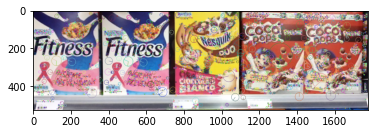

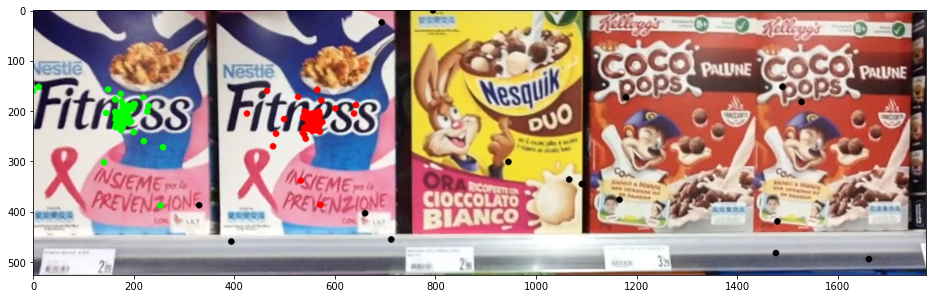

End of model nr. 24; position: (539.97,195.91), width: 348.30px, height: 499.74px
End of model nr. 24; position: (161.27,192.22), width: 362.07px, height: 507.83px


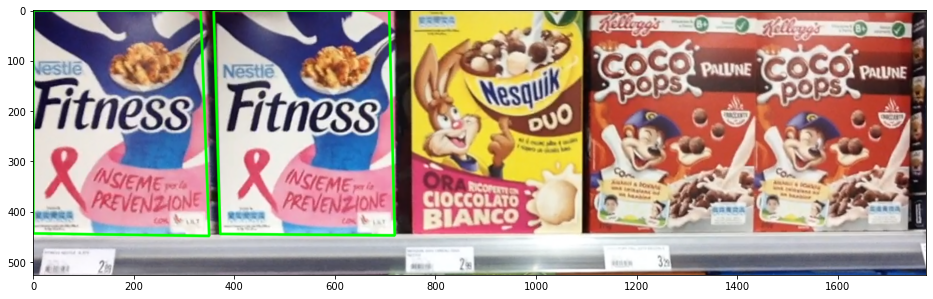

In [4]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler  
import hdbscan

# 'scenes/m1.png', 'scenes/m2.png', 'scenes/m3.png', 'scenes/m4.png', 'scenes/m5.png'
img_train = cv2.imread('scenes/m4.png')[:,:,::-1] # trainImage
img_querys = ['models/0.jpg',
              'models/1.jpg',
              'models/11.jpg',
              'models/19.jpg',
              'models/24.jpg',
              'models/25.jpg',
              'models/26.jpg'] # queryImages

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_train = sift.detect(img_train)

# Visualize keypoints with drawKeypoints.
img = cv2.drawKeypoints(img_train,kp_train,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()

# Defining parameters for algorithm
flann = set_flann_matcher()

for path in img_querys:
    kp_train, des_train = sift.compute(img_train, kp_train)
    
    img_query = cv2.imread(path)[:,:,::-1] # queryImage
    kp_query = sift.detect(img_query)
    kp_query, des_query = sift.compute(img_query, kp_query)
    points_query = np.array([k.pt for k in kp_query])
    centroid_query = find_centroid(points_query)
    # Find a support set of vectors (x, y, length) connecting keypoints to their centroid
    # (and print them on query image to check - commented)
    img_cpy = img_query.copy()
    vectors_query = find_vectors(points_query, centroid_query, img_cpy)
    
    # Matching and finding the 3 closest elements for each query descriptor.
    # Choice of the number 3 is due to the fact that the highest number of instances
    # of a single model in the given scenes is 2, so with Lowe's ratio test we can't
    # just discard the matches if the first 2 are similar.
    # (3 is for the proof of concept; should be 4 for the final task)
    matches = flann.knnMatch(des_query,des_train,k=3)

    good = []
    goodvectors = []
    single_corr = 0
    double_corr = 0
    # Knowing that matches are ordered from the best going down, we iteratively check
    # distance ratios bw m and n, m and o. If the first check result in m being way better
    # than n, the comparison stops and m is considered a good match, else the second check is
    # performed: if the result is m being way better than o, both m and n are considered
    # good matches, else the three are all discarded.
    for m,n,o in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
            single_corr += 1
        else:
            if m.distance < 0.7*o.distance:
                good.append(m)
                good.append(n)
                double_corr += 1
#     for m,n in matches:
#         if m.distance < 0.7*n.distance:
#              good.append(m)
    
    goodvectors = np.array([ vectors_query[m.queryIdx] for m in good ])
    
    # Draw the vectors for the good matches' keypoints on the model
#     img_cpy2 = img_query.copy()
#     src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ])
#     for i in range(len(good)):
#         cv2.arrowedLine(img_cpy2, (src_pts[i][0].astype(np.int32),src_pts[i][1].astype(np.int32)), (centroid_query[0].astype(np.int32),centroid_query[1].astype(np.int32)), (255,0,0), 1)
#     plt.imshow(img_cpy2)
#     plt.show()
    
    MIN_MATCH_COUNT = 70
    if (single_corr > MIN_MATCH_COUNT) or (double_corr > MIN_MATCH_COUNT):
        # There are enough matches for either a single instance or multiple instances
        
        # building the correspondences arrays of good matches
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        
        if (double_corr > MIN_MATCH_COUNT):
            # CASE MULTIPLE INSTANCES
#             print("{} double correspondences ({} single c.): possible double instance of model {}".format(double_corr, single_corr, img_num(path)))
#             print("Further inspection will follow")

            # Here we proceed by considering the possibility there are multiple instances of this model.
            # Hence we need to find the corresponding centroid for each keypoint in order to cluster them,
            # and we do so by casting votes: on the scene we'll project the corresponding vector
            # from each keypoint (properly scaled by the ratio of sizes of the keypoints) and we find
            # the ending point of the so defined vector and store it in 'votes', on which we'll then perform
            # a clustering algorithm of choice (DBSCAN or HDBSCAN). The centroids of the found clusters will
            # then be considered the centroids of the istances of the model in the scene, and the keypoints
            # that voted for those points will all belong to a group of their own, from which we can
            # finally perform the homography.
            # To extract the keypoints that voted for a point that belong in a cluster, we just select all
            # of those that have the same label value after the clustering phase.

            # Extraction of the well matched keypoints to determine ratio of features
            # (kp.size: diameter of the meaningful keypoint neighborhood)
            goodkp_query = np.array([ kp_query[m.queryIdx] for m in good ])
            goodkp_train = np.array([ kp_train[m.trainIdx] for m in good ])

            votes = []
            for (a_kp_query, a_kp_train, a_vec, dst_pt) in zip(goodkp_query, goodkp_train, goodvectors, dst_pts):
                dst_pt = dst_pt.reshape(2)
                size_query = a_kp_query.size
                size_train = a_kp_train.size
                ratio = size_train/size_query
                len_query = a_vec[2] # (x, y, len)
                len_train = len_query*ratio
                x_query = a_vec[0]
                x_train = x_query*len_train
                y_query = a_vec[1]
                y_train = y_query*len_train
                # (x_train, y_train) is the vector from the keypoint on the scene to its corresponding centroid
                centroid_vote = [(dst_pt[0] + x_train), (dst_pt[1] + y_train)]
                votes.append([centroid_vote[0], centroid_vote[1]])
            votes = np.array(votes).reshape(-1,2)

            # Draw the vectors
#             img_cpyb = img_train.copy()
#             dst_ptsb = dst_pts.copy().reshape(-1,2)
#             for i in range(len(good)):
#                cv2.arrowedLine(img_cpyb, (dst_ptsb[i][0].astype(np.int32),dst_ptsb[i][1].astype(np.int32)), (votes[i][0].astype(np.int32),votes[i][1].astype(np.int32)), (255,0,0), 1)
#             plt.imshow(img_cpyb)
#             plt.show()

            # Draw the centroids votes
#             img_cpyb = img_train.copy()
#             for vote in votes:
#                cv2.circle(img_cpyb, (vote[0].astype(np.int32),vote[1].astype(np.int32)), radius=5, color=(0, 0, 255), thickness=cv2.FILLED)
#             plt.figure(figsize=(16,8))
#             plt.imshow(img_cpyb)
#             plt.show()

            labels = perform_clustering_hdbscan(votes, img_train, double_corr)
            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#             n_noise_ = list(labels).count(-1)
#             print('Estimated number of clusters: %d' % n_clusters_)
#             print('Estimated number of noise points: %d' % n_noise_)
        elif (single_corr > MIN_MATCH_COUNT):
            # CASE SINGLE INSTANCE
            n_clusters_ = 1
        
        # At this point we have to perform the homography estimate for each label,
        # or just once if the first check was false (not enough double matches for multiple
        # instances of a single model) but there are still enough good matches for a single
        # instance. For each iteration the procedure is the same, done by selecting just
        # the proper keypoints each time (or all of them, for the single instance case)
        sel_src_pts = src_pts.copy()
        sel_dst_pts = dst_pts.copy()
        for i in range(n_clusters_):
            if (n_clusters_ != 1):
                class_member_mask = (labels == i)
                sel_src_pts = src_pts[class_member_mask]
                sel_dst_pts = dst_pts[class_member_mask]
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(sel_src_pts, sel_dst_pts, cv2.RANSAC, 5.0)

            # Mask of discarded point used in visualization
            matchesMask = mask.ravel().tolist()

            # Corners of the query image
            h,w = img_query.shape[:2]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M)

            # In order to avoid wrong matches without increasing too much the min number of keypoint matches,
            # that would instead result in discarding right matches with a low number of keypoints,
            # we compare the height/width ratio of the model object to the ratio of the found object
            # and reject the wrongfully found match (ratios too different).
            # A second test has been added in order to check how rectangular-like is the shape of
            # the found object.
            flag1 = is_rectangle(dst.reshape(4,2))
            flag2, h_new, w_new = check_ratio(h, w, dst.reshape(4,2))
            if flag1 and flag2:
                # Compute the centroid of the corners, thus of the found object
                centroid = find_centroid(dst)

                # Some points may fall outside scene image boundaries after the perspective transformation,
                # and that may due to partially cut images. The two lines below are just to prevent the error
                # that would come up when trying to draw them.
                for i in dst:
                    i[i<0] = 0

                # Drawing the bounding box
                # cv2.polylines(img, pts, isClosed, color[, thickness[, lineType[, shift]]])
                img_train = cv2.polylines(np.array(img_train),[dst.astype(np.int32)],True,[0,255,0],3,cv2.LINE_AA)

                # Update: delete set of keypoints of the object detected, not to be matched again with next models
                kp_train = delete_keypoints(dst.reshape(4,2), kp_train)
                print("End of model nr. {}; position: ({},{}), width: {}px, height: {}px".format(img_num(path), format(centroid[0], '.2f'), format(centroid[1], '.2f'), format(w_new, '.2f'), format(h_new, '.2f')))
#             else:
#                 reason = ''
#                 if not flag1:
#                     reason += 'shape not rectangular; '
#                 if not flag2:
#                     reason += 'h/w ratio; '
#                 print("REJECTED nr. {} due to {}".format(img_num(path), reason))
    else:
#         print( "{}: Not enough matches are found - {}/{}".format(path, len(good), MIN_MATCH_COUNT) )
        matchesMask = None
    
plt.figure(figsize=(16,8))
plt.imshow(img_train)
plt.show()

## ----------------------------------------------------------- Step C: -----------------------------------------------------------

*Step C (optional) - Whole shelve challenge:*

>Test on scene image: {h1.jpg, h2.jpg, h3.jpg, h4.jpg, h5.jpg}<br>
>Use product images: {from 0.jpg to 23.jpg}

In [17]:
# Support fnc - Step C (only one it differs from the above set of functions)
def perform_clustering_hdbscan(votes, img, n_corr):

    # #############################################################################

    # Compute HDBSCAN
    min_s = int(7)
    db = hdbscan.HDBSCAN(min_cluster_size=min_s)
    labels = db.fit_predict(votes)

    # #############################################################################
    
    return labels

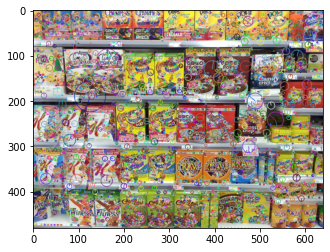

End of model nr. 0; position: (283.81,338.94), width: 57.96px, height: 74.39px
End of model nr. 0; position: (222.80,338.48), width: 58.43px, height: 74.15px
End of model nr. 1; position: (344.37,345.33), width: 58.21px, height: 71.50px
End of model nr. 1; position: (465.00,340.77), width: 58.62px, height: 80.72px
End of model nr. 1; position: (405.84,345.29), width: 58.63px, height: 72.80px
End of model nr. 3; position: (218.86,440.85), width: 62.33px, height: 81.10px
End of model nr. 3; position: (338.34,443.16), width: 60.10px, height: 82.17px
End of model nr. 3; position: (277.88,441.53), width: 63.63px, height: 82.50px
End of model nr. 4; position: (101.64,136.54), width: 67.67px, height: 99.88px
End of model nr. 4; position: (166.21,137.26), width: 71.74px, height: 101.25px
End of model nr. 5; position: (302.13,126.87), width: 47.70px, height: 73.04px
End of model nr. 7; position: (444.08,136.28), width: 63.47px, height: 104.21px
End of model nr. 7; position: (412.00,259.35), wid

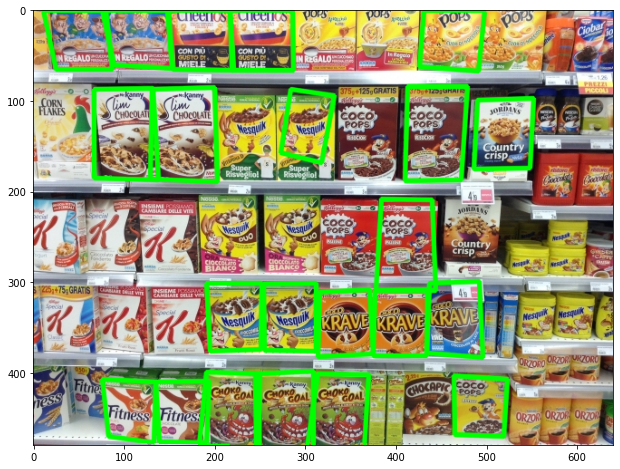

In [18]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler  
import hdbscan

# 'scenes/h1.jpg', 'scenes/h2.jpg', 'scenes/h3.jpg', 'scenes/h4.jpg', 'scenes/h5.jpg'
img_train = cv2.imread('scenes/h5.jpg')[:,:,::-1] # trainImage
img_querys = ['models/0.jpg',
              'models/1.jpg',
              'models/2.jpg',
              'models/3.jpg',
              'models/4.jpg',
              'models/5.jpg',
              'models/6.jpg',
              'models/7.jpg',
              'models/8.jpg',
              'models/9.jpg',
              'models/10.jpg',
              'models/11.jpg',
              'models/12.jpg',
              'models/13.jpg',
              'models/14.jpg',
              'models/15.jpg',
              'models/16.jpg',
              'models/17.jpg',
              'models/18.jpg',
              'models/19.jpg',
              'models/20.jpg',
              'models/21.jpg',
              'models/22.jpg',
              'models/23.jpg'] # queryImages

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_train = sift.detect(img_train)

# Visualize keypoints with drawKeypoints.
img = cv2.drawKeypoints(img_train,kp_train,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()

# Defining parameters for algorithm
flann = set_flann_matcher()

for path in img_querys:
    kp_train, des_train = sift.compute(img_train, kp_train)
    
    img_query = cv2.imread(path)[:,:,::-1] # queryImage
    kp_query = sift.detect(img_query)
    kp_query, des_query = sift.compute(img_query, kp_query)
    points_query = np.array([k.pt for k in kp_query])
    centroid_query = find_centroid(points_query)
    # Find a support set of vectors (x, y, length) connecting keypoints to their centroid
    # (and print them on query image to check - commented)
    img_cpy = img_query.copy()
    vectors_query = find_vectors(points_query, centroid_query, img_cpy)
    
    # Matching and finding the 4 closest elements for each query descriptor.
    # Choice of the number 4 is due to the fact that the highest number of instances
    # of a single model in the given scenes is 3, so with Lowe's ratio test we can't
    # just discard the matches if the first 3 are similar.
    matches = flann.knnMatch(des_query,des_train,k=4)

    good = []
    goodvectors = []
    single_corr = 0
    multi_corr = 0
    # Knowing that matches are ordered from the best going down, we iteratively check
    # distance ratios bw m and n, m and o, m and p. If the first check result in m being way better
    # than n, the comparison stop and m is considered a good match, else the second check is
    # performed: if the result is m being way better than o, both m and n are considered
    # good matches, else the third check is performed; if the result is m being way better than p,
    # the three are considered good matches, otherwise all four are discarded.
    for m,n,o,p in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
            single_corr += 1
        elif m.distance < 0.7*o.distance:
            good.append(m)
            good.append(n)
            multi_corr += 1
        elif m.distance < 0.7*p.distance:
            good.append(m)
            good.append(n)
            good.append(o)
            multi_corr += 1
                
#     for m,n in matches:
#         if m.distance < 0.7*n.distance:
#              good.append(m)
    
    goodvectors = np.array([ vectors_query[m.queryIdx] for m in good ])
    
    # Draw the vectors for the good matches' keypoints on the model
#     img_cpy2 = img_query.copy()
#     src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ])
#     for i in range(len(good)):
#         cv2.arrowedLine(img_cpy2, (src_pts[i][0].astype(np.int32),src_pts[i][1].astype(np.int32)), (centroid_query[0].astype(np.int32),centroid_query[1].astype(np.int32)), (255,0,0), 1)
#     plt.imshow(img_cpy2)
#     plt.show()
    
    # Here we are dealing with big images, low resolutions and a lot of instances per image.
    # The total number of matches will be low, relatively to the number of detailed keypoints
    # found for each model. The threshold is thus set very low, and we let the clustering
    # algorithm and the shape check do the hard work to discard the (many) wrong matches.
    MIN_MATCH_COUNT = 8
    if (single_corr > MIN_MATCH_COUNT) or (multi_corr > MIN_MATCH_COUNT):
        # There are enough matches for either a single instance or multiple instances
        
        # building the correspondences arrays of good matches
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        
        if (multi_corr > MIN_MATCH_COUNT):
            # CASE MULTIPLE INSTANCES
#             print("{} multiple c. ({} single c.): possible multiple instance of model {}, further inspection will follow".format(multi_corr, single_corr, img_num(path)))

            # Here we proceed by considering the possibility there are multiple instances of this model.
            # Hence we need to find the corresponding centroid for each keypoint in order to cluster them,
            # and we do so by casting votes: on the scene we'll project the corresponding vector
            # from each keypoint (properly scaled by the ratio of sizes of the keypoints) and we find
            # the ending point of the so defined vector and store it in 'votes', on which we'll then perform
            # a clustering algorithm of choice (DBSCAN). The centroids of the found clusters will
            # then be considered the centroids of the istances of the model in the scene, and the keypoints
            # that voted for those points will all belong to a group of their own, from which we can
            # finally perform the homography.
            # To extract the keypoints that voted for a point that belong in a cluster, we just select all
            # of those that have the same label value after the clustering phase.

            # Extraction of the well matched keypoints to determine ratio of features
            # (kp.size: diameter of the meaningful keypoint neighborhood)
            goodkp_query = np.array([ kp_query[m.queryIdx] for m in good ])
            goodkp_train = np.array([ kp_train[m.trainIdx] for m in good ])

            votes = []
            for (a_kp_query, a_kp_train, a_vec, dst_pt) in zip(goodkp_query, goodkp_train, goodvectors, dst_pts):
                dst_pt = dst_pt.reshape(2)
                size_query = a_kp_query.size
                size_train = a_kp_train.size
                ratio = size_train/size_query
                len_query = a_vec[2] # (x, y, len)
                len_train = len_query*ratio
                x_query = a_vec[0]
                x_train = x_query*len_train
                y_query = a_vec[1]
                y_train = y_query*len_train
                # (x_train, y_train) is the vector from the keypoint on the scene to its corresponding centroid
                centroid_vote = [(dst_pt[0] + x_train), (dst_pt[1] + y_train)]
                votes.append([centroid_vote[0], centroid_vote[1]])
            votes = np.array(votes).reshape(-1,2)

            # Draw the vectors
#             img_cpyb = img_train.copy()
#             dst_ptsb = dst_pts.copy().reshape(-1,2)
#             for i in range(len(good)):
#                cv2.arrowedLine(img_cpyb, (dst_ptsb[i][0].astype(np.int32),dst_ptsb[i][1].astype(np.int32)), (votes[i][0].astype(np.int32),votes[i][1].astype(np.int32)), (255,0,0), 1)
#             plt.imshow(img_cpyb)
#             plt.show()

            # Draw the centroids votes
#             img_cpyb = img_train.copy()
#             for vote in votes:
#                cv2.circle(img_cpyb, (vote[0].astype(np.int32),vote[1].astype(np.int32)), radius=5, color=(0, 0, 255), thickness=cv2.FILLED)
#             plt.figure(figsize=(16,8))
#             plt.imshow(img_cpyb)
#             plt.show()

            labels = perform_clustering_hdbscan(votes, img_train, multi_corr)
            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#             n_noise_ = list(labels).count(-1)
#             print('Estimated number of clusters: %d' % n_clusters_)
#             print('Estimated number of noise points: %d' % n_noise_)
        elif (single_corr > MIN_MATCH_COUNT):
            # CASE SINGLE INSTANCE
            n_clusters_ = 1
        
#         if n_clusters_ == 0:
#             print("Inspection unsuccessful: there seem to be no model {} in this scene".format(img_num(path)))
        # At this point we have to perform the homography estimate for each label,
        # or just once if the first check was false (not enough double matches for multiple
        # instances of a single model) but there are still enough good matches for a single
        # instance. For each iteration the procedure is the same, done by selecting just
        # the proper keypoints each time (or all of them, for the single instance case)
        sel_src_pts = src_pts.copy()
        sel_dst_pts = dst_pts.copy()
        for i in range(n_clusters_):
            if (n_clusters_ != 1):
                class_member_mask = (labels == i)
                sel_src_pts = src_pts[class_member_mask]
                sel_dst_pts = dst_pts[class_member_mask]
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(sel_src_pts, sel_dst_pts, cv2.RANSAC, 5.0)
            if M is None:
#                 print("Homography was found empty; skipping")
                continue

            # Mask of discarded point used in visualization
            matchesMask = mask.ravel().tolist()

            # Corners of the query image
            h,w = img_query.shape[:2]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M)

            # In order to avoid wrong matches without increasing too much the min number of keypoint matches,
            # that would instead result in discarding right matches with a low number of keypoints,
            # we compare the height/width ratio of the model object to the ratio of the found object
            # and reject the wrongfully found match (ratios too different).
            # A second test has been added in order to check how rectangular-like is the shape of
            # the found object.
            flag1 = is_rectangle(dst.reshape(4,2))
            flag2, h_new, w_new = check_ratio(h, w, dst.reshape(4,2))
            if flag1 and flag2:
                # Compute the centroid of the corners, thus of the found object
                centroid = find_centroid(dst)

                # Some points may fall outside scene image boundaries after the perspective transformation,
                # and that may due to partially cut images. The two lines below are just to prevent the error
                # that would come up when trying to draw them.
                for i in dst:
                    i[i<0] = 0

                # Drawing the bounding box
                # cv2.polylines(img, pts, isClosed, color[, thickness[, lineType[, shift]]])
                img_train = cv2.polylines(np.array(img_train),[dst.astype(np.int32)],True,[0,255,0],3,cv2.LINE_AA)

                # Update: delete set of keypoints of the object detected, not to be matched again with next models
                kp_train = delete_keypoints(dst.reshape(4,2), kp_train)
                print("End of model nr. {}; position: ({},{}), width: {}px, height: {}px".format(img_num(path), format(centroid[0], '.2f'), format(centroid[1], '.2f'), format(w_new, '.2f'), format(h_new, '.2f')))
#             else:
                
#                 reason = ''
#                 if not flag1:
#                     reason += 'shape not rectangular; '
#                 if not flag2:
#                     reason += 'h/w ratio; '
#                 print("REJECTED nr. {} due to {}".format(img_num(path), reason))
    else:
#         print( "{}: Not enough matches are found - {}/{}".format(path, len(good), MIN_MATCH_COUNT) )
        matchesMask = None
    
plt.figure(figsize=(16,8))
plt.imshow(img_train)
plt.show()